Dataset shape: (350085, 67)

First 5 rows:
Columns in the dataset:
['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vacc

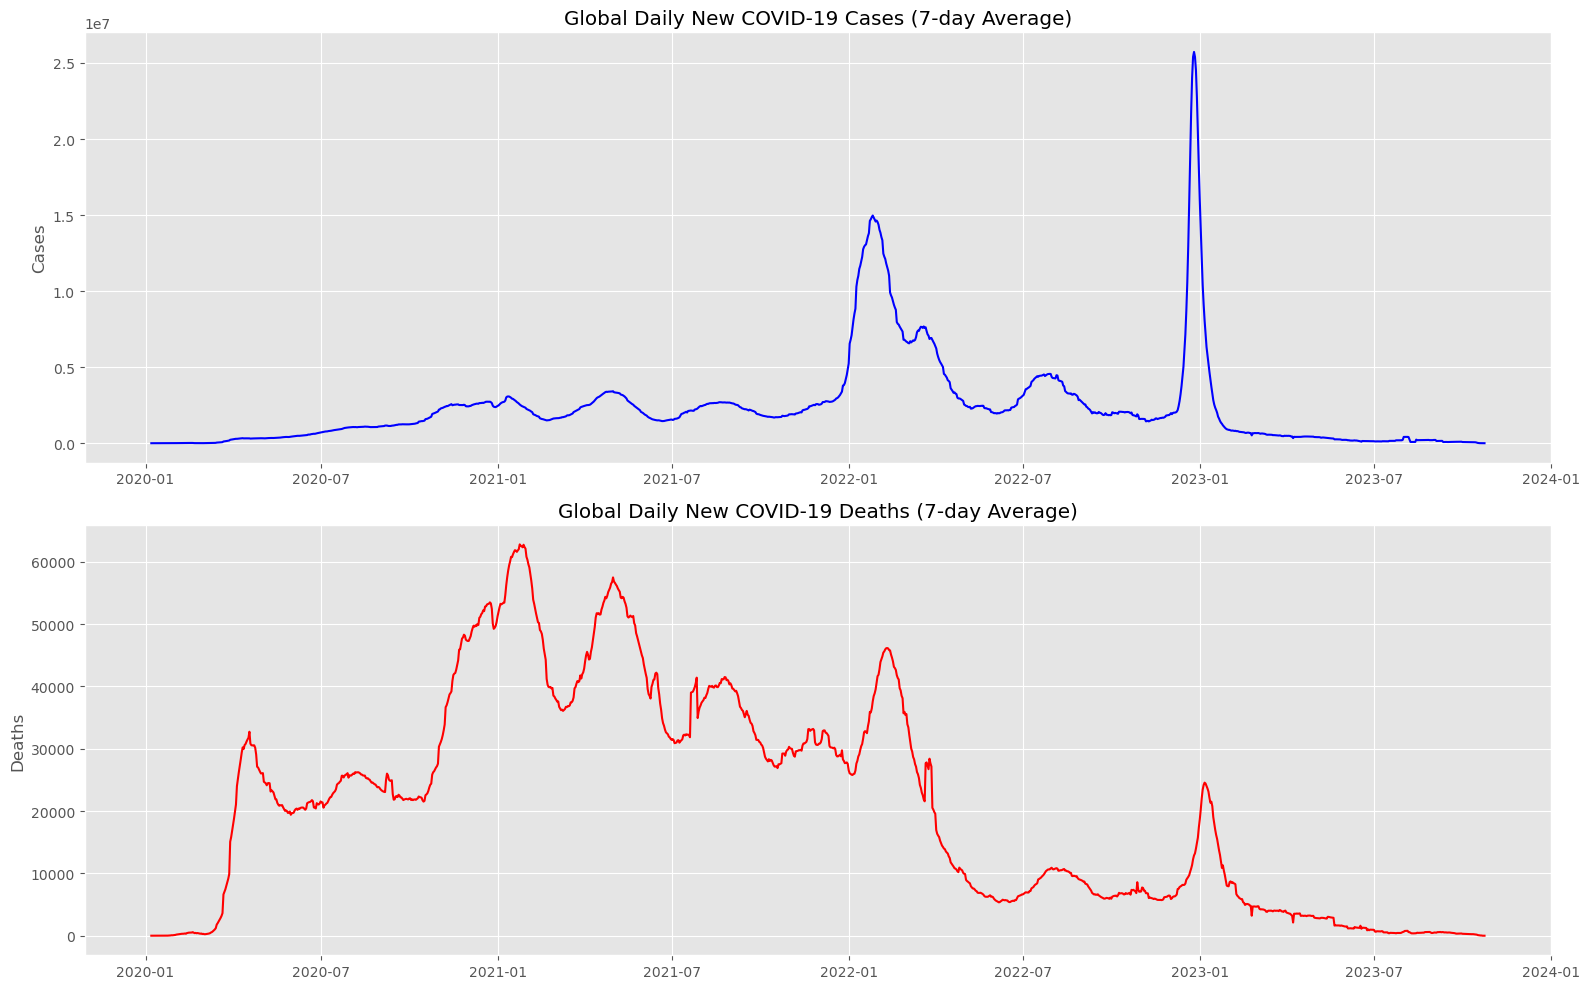

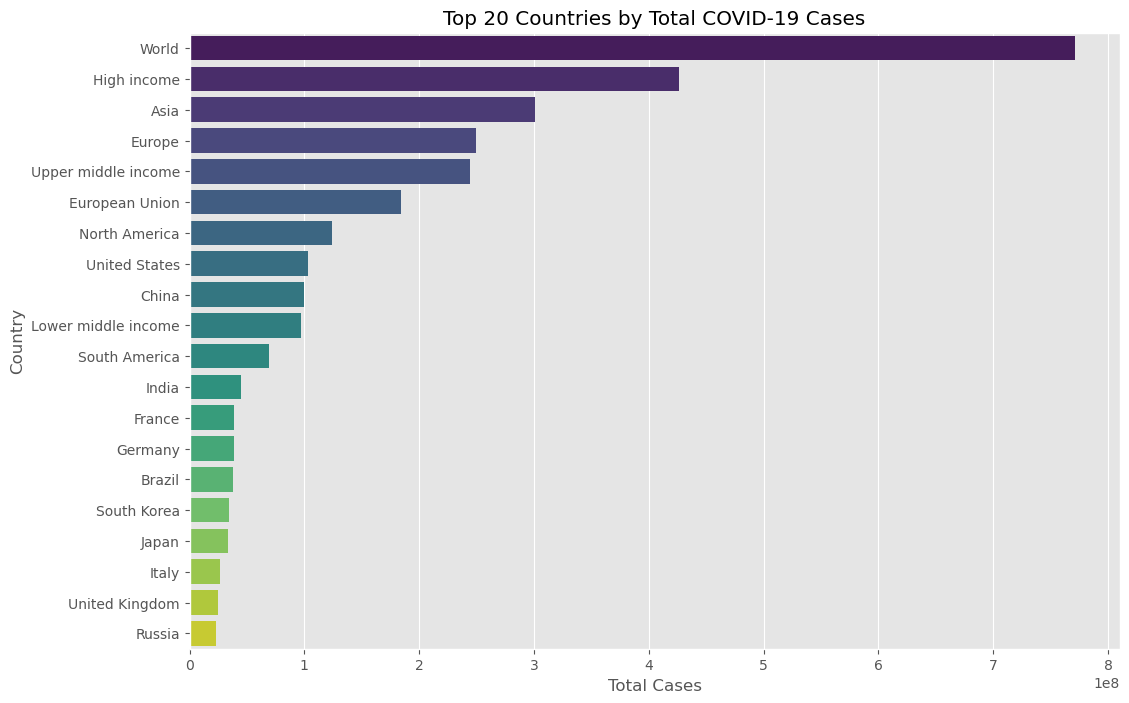

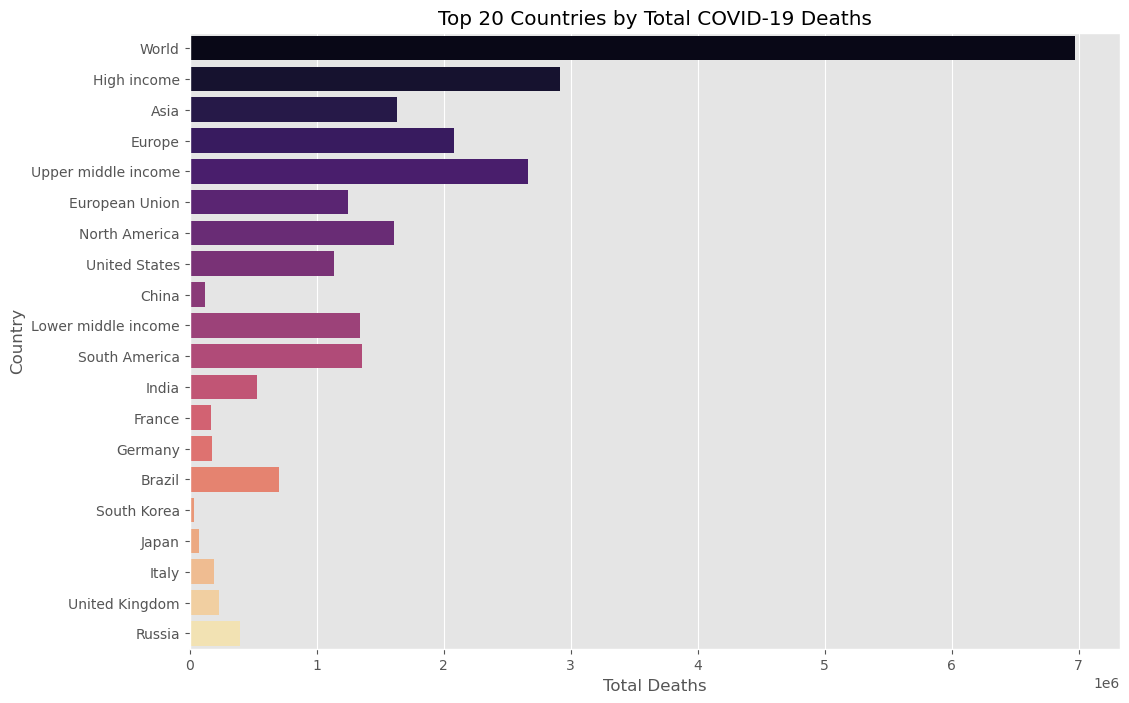

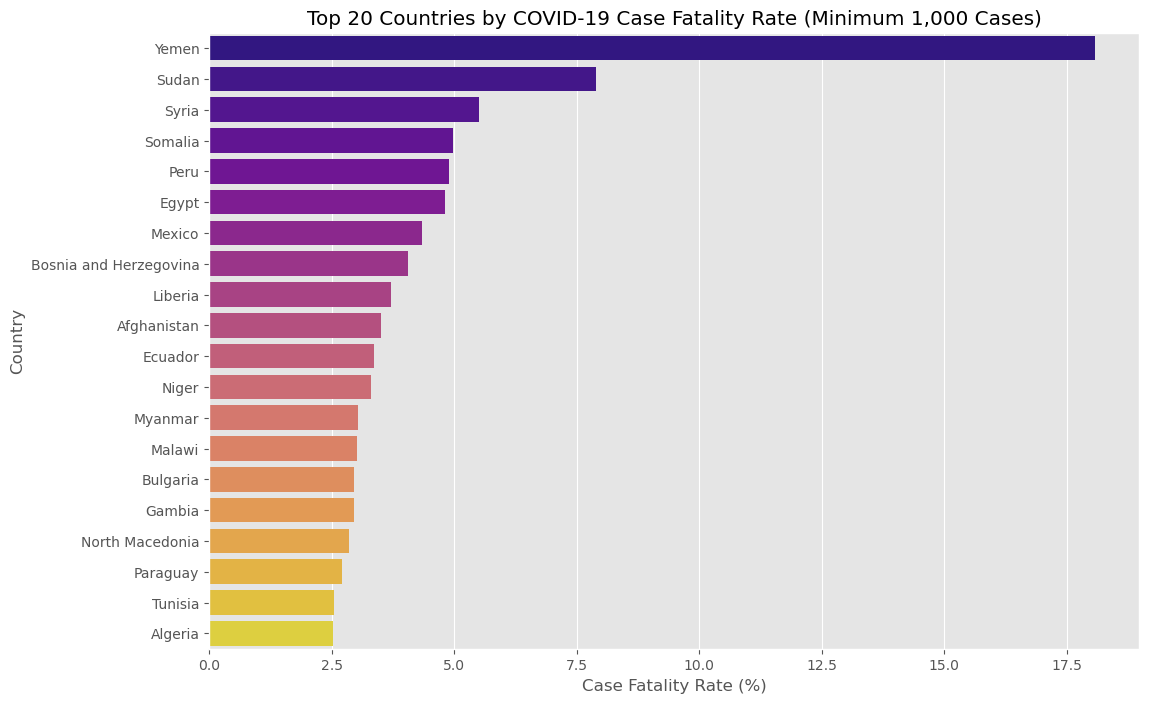

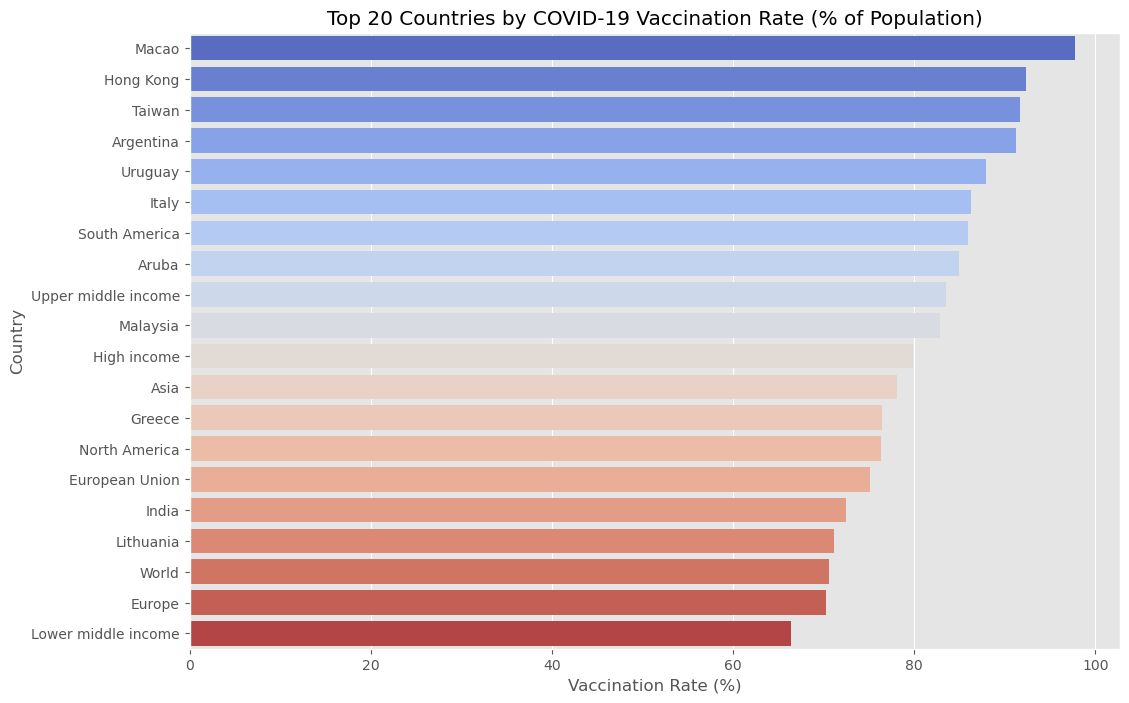

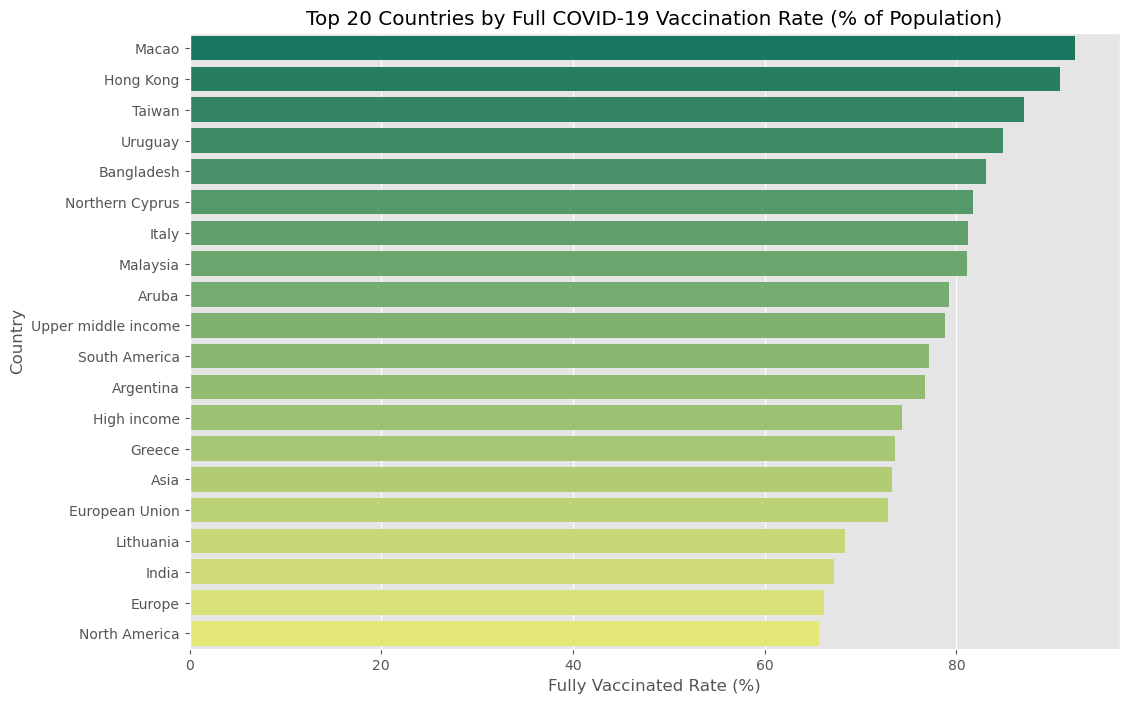

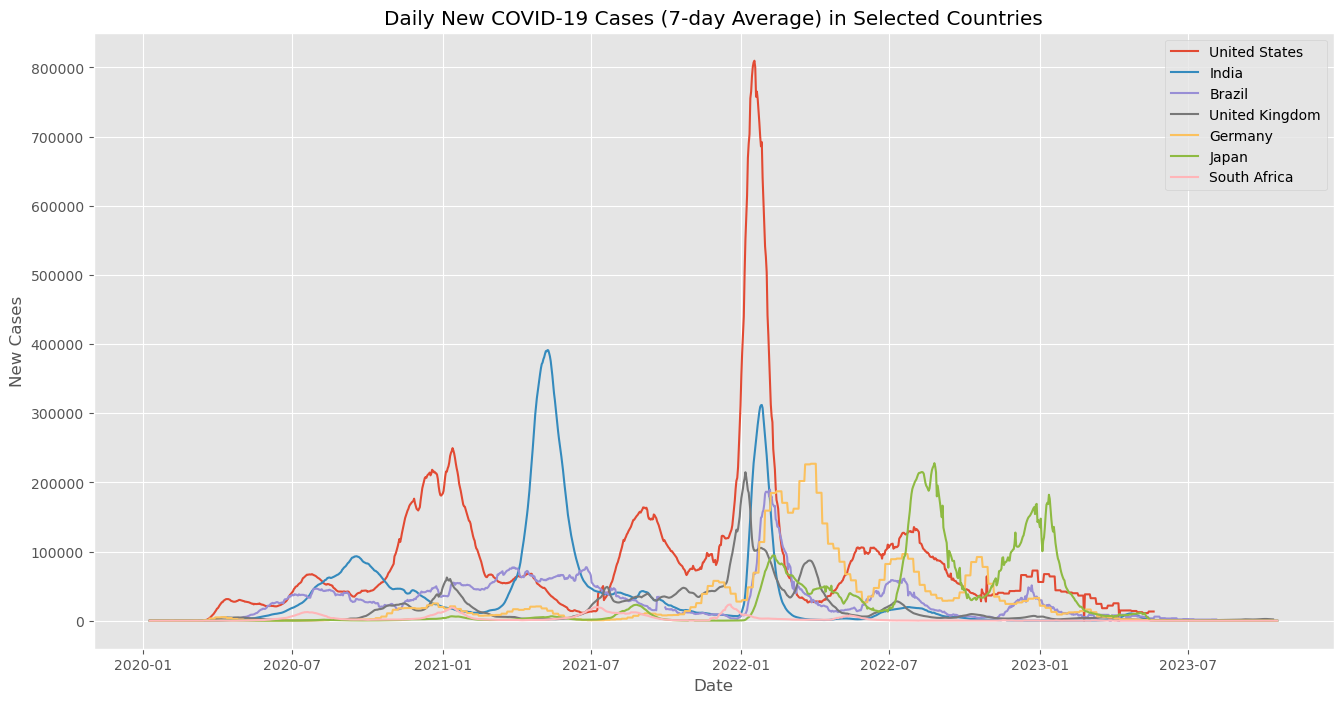

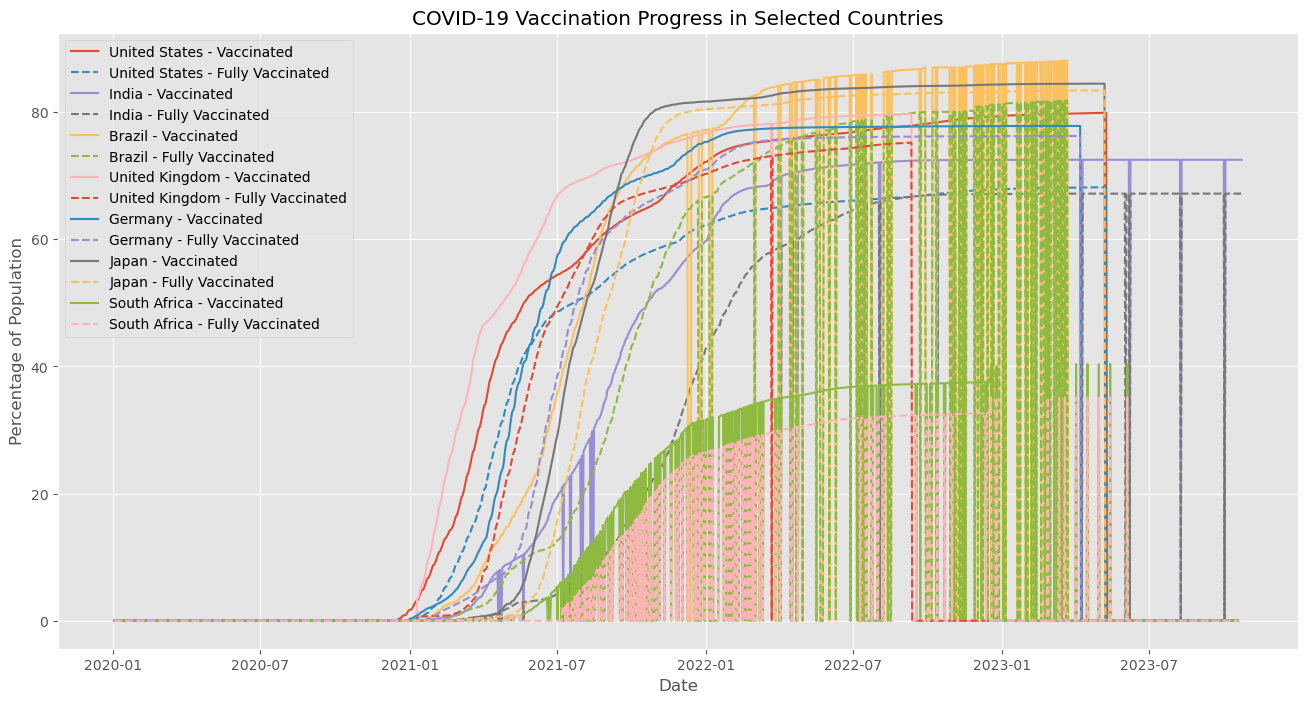

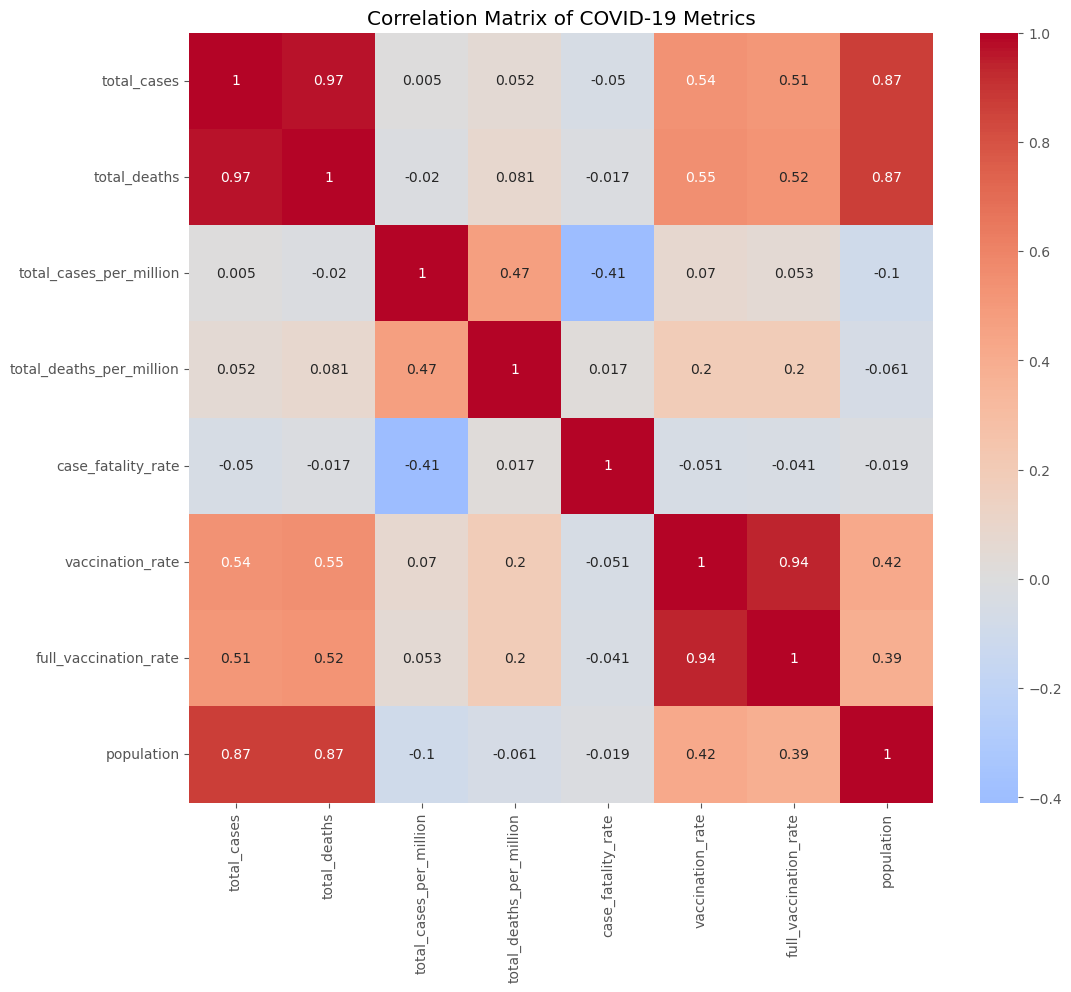

Analysis complete. Cleaned data saved to 'cleaned_covid_data.csv'


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for plots
plt.style.use('ggplot')
%matplotlib inline

# Load the dataset
data = pd.read_csv('owid-covid-data.csv')

# Display basic information about the dataset
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
data.head()


# Display column information
print("Columns in the dataset:")
print(data.columns.tolist())

# Check data types and missing values
print("\nData types and missing values:")
data_info = pd.DataFrame({
    'Data Type': data.dtypes,
    'Missing Values': data.isnull().sum(),
    'Missing %': (data.isnull().sum() / len(data)) * 100
})
data_info.sort_values(by='Missing %', ascending=False)



# Convert date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Select columns we'll focus on for analysis
key_columns = [
    'iso_code', 'continent', 'location', 'date', 
    'total_cases', 'new_cases', 'total_deaths', 'new_deaths',
    'total_cases_per_million', 'new_cases_per_million',
    'total_deaths_per_million', 'new_deaths_per_million',
    'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
    'population'
]


# Create a filtered dataframe with our key columns
df = data[key_columns].copy()

# Fill missing values for vaccination data with 0 (assuming no vaccinations yet)
vaccination_cols = ['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']
df[vaccination_cols] = df[vaccination_cols].fillna(0)

# Calculate some additional metrics
df['case_fatality_rate'] = (df['total_deaths'] / df['total_cases']) * 100
df['vaccination_rate'] = (df['people_vaccinated'] / df['population']) * 100
df['full_vaccination_rate'] = (df['people_fully_vaccinated'] / df['population']) * 100

# Display cleaned data info
print("Cleaned dataset info:")
df.info()





# Create a global aggregate by date
global_df = df.groupby('date').agg({
    'new_cases': 'sum',
    'new_deaths': 'sum',
    'total_cases': 'sum',
    'total_deaths': 'sum',
    'people_vaccinated': 'sum',
    'people_fully_vaccinated': 'sum'
}).reset_index()

# Calculate 7-day rolling averages for smoothing
global_df['new_cases_7day_avg'] = global_df['new_cases'].rolling(7).mean()
global_df['new_deaths_7day_avg'] = global_df['new_deaths'].rolling(7).mean()

# Plot global new cases and deaths over time
plt.figure(figsize=(16, 10))

# New cases plot
plt.subplot(2, 1, 1)
plt.plot(global_df['date'], global_df['new_cases_7day_avg'], color='blue')
plt.title('Global Daily New COVID-19 Cases (7-day Average)')
plt.ylabel('Cases')
plt.grid(True)

# New deaths plot
plt.subplot(2, 1, 2)
plt.plot(global_df['date'], global_df['new_deaths_7day_avg'], color='red')
plt.title('Global Daily New COVID-19 Deaths (7-day Average)')
plt.ylabel('Deaths')
plt.grid(True)

plt.tight_layout()
plt.show()



# Get the most recent data for each country
latest_data = df.sort_values('date').groupby('location').last().reset_index()

# Select top 20 countries by total cases
top_countries = latest_data.sort_values('total_cases', ascending=False).head(20)

# Plot total cases by country
plt.figure(figsize=(12, 8))
sns.barplot(x='total_cases', y='location', data=top_countries, palette='viridis')
plt.title('Top 20 Countries by Total COVID-19 Cases')
plt.xlabel('Total Cases')
plt.ylabel('Country')
plt.show()

# Plot total deaths by country
plt.figure(figsize=(12, 8))
sns.barplot(x='total_deaths', y='location', data=top_countries, palette='magma')
plt.title('Top 20 Countries by Total COVID-19 Deaths')
plt.xlabel('Total Deaths')
plt.ylabel('Country')
plt.show()



# Filter countries with at least 1000 cases to get meaningful CFR
cfr_df = latest_data[latest_data['total_cases'] > 1000].sort_values('case_fatality_rate', ascending=False)

# Plot top 20 countries by CFR
plt.figure(figsize=(12, 8))
sns.barplot(x='case_fatality_rate', y='location', data=cfr_df.head(20), palette='plasma')
plt.title('Top 20 Countries by COVID-19 Case Fatality Rate (Minimum 1,000 Cases)')
plt.xlabel('Case Fatality Rate (%)')
plt.ylabel('Country')
plt.show()


# Select countries with vaccination data
vaccination_df = latest_data[latest_data['people_vaccinated'] > 0].sort_values('vaccination_rate', ascending=False)

# Plot top 20 countries by vaccination rate
plt.figure(figsize=(12, 8))
sns.barplot(x='vaccination_rate', y='location', data=vaccination_df.head(20), palette='coolwarm')
plt.title('Top 20 Countries by COVID-19 Vaccination Rate (% of Population)')
plt.xlabel('Vaccination Rate (%)')
plt.ylabel('Country')
plt.show()

# Plot full vaccination rates
full_vaccination_df = latest_data[latest_data['people_fully_vaccinated'] > 0].sort_values('full_vaccination_rate', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='full_vaccination_rate', y='location', data=full_vaccination_df.head(20), palette='summer')
plt.title('Top 20 Countries by Full COVID-19 Vaccination Rate (% of Population)')
plt.xlabel('Fully Vaccinated Rate (%)')
plt.ylabel('Country')
plt.show()



# Select some countries for comparison
selected_countries = ['United States', 'India', 'Brazil', 'United Kingdom', 'Germany', 'Japan', 'South Africa']

# Filter data for selected countries
country_df = df[df['location'].isin(selected_countries)]

# Plot new cases over time for selected countries
plt.figure(figsize=(16, 8))
for country in selected_countries:
    country_data = country_df[country_df['location'] == country]
    plt.plot(country_data['date'], country_data['new_cases'].rolling(7).mean(), label=country)

plt.title('Daily New COVID-19 Cases (7-day Average) in Selected Countries')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.grid(True)
plt.show()

# Plot vaccination progress over time for selected countries
plt.figure(figsize=(16, 8))
for country in selected_countries:
    country_data = country_df[country_df['location'] == country]
    plt.plot(country_data['date'], country_data['vaccination_rate'], label=f'{country} - Vaccinated')
    plt.plot(country_data['date'], country_data['full_vaccination_rate'], '--', label=f'{country} - Fully Vaccinated')

plt.title('COVID-19 Vaccination Progress in Selected Countries')
plt.xlabel('Date')
plt.ylabel('Percentage of Population')
plt.legend()
plt.grid(True)
plt.show()




# Select numeric columns for correlation analysis
numeric_cols = [
    'total_cases', 'total_deaths', 'total_cases_per_million', 
    'total_deaths_per_million', 'case_fatality_rate',
    'vaccination_rate', 'full_vaccination_rate', 'population'
]

# Calculate correlation matrix
corr_matrix = latest_data[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of COVID-19 Metrics')
plt.show()




df.to_csv('cleaned_covid_data.csv', index=False)
print("Analysis complete. Cleaned data saved to 'cleaned_covid_data.csv'")
